# 06. 임베딩을 사용한 자연어 처리

> 임베딩(embedding)은 고차원 공간의 벡터로 단어를 표현하는 기법입니다.

# 데이터 준비

**News Headlines Dataset**

[Docs](https://rishabhmisra.github.io/NewsHeadlinesDataset.pdf) <br/>
[파일 다운로드, Kaggle](https://www.kaggle.com/datasets/rmisra/news-headlines-dataset-for-sarcasm-detection)


In [1]:
import json
from bs4 import BeautifulSoup
import string

stopwords = ["a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at",
             "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do",
             "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", "have", "having",
             "he", "hed", "hes", "her", "here", "heres", "hers", "herself", "him", "himself", "his", "how",
             "hows", "i", "id", "ill", "im", "ive", "if", "in", "into", "is", "it", "its", "itself",
             "lets", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought",
             "our", "ours", "ourselves", "out", "over", "own", "same", "she", "shed", "shell", "shes", "should",
             "so", "some", "such", "than", "that", "thats", "the", "their", "theirs", "them", "themselves", "then",
             "there", "theres", "these", "they", "theyd", "theyll", "theyre", "theyve", "this", "those", "through",
             "to", "too", "under", "until", "up", "very", "was", "we", "wed", "well", "were", "weve", "were",
             "what", "whats", "when", "whens", "where", "wheres", "which", "while", "who", "whos", "whom", "why",
             "whys", "with", "would", "you", "youd", "youll", "youre", "youve", "your", "yours", "yourself",
             "yourselves"]

table = str.maketrans('', '', string.punctuation)

datastore = []
with open("Sarcasm_Headlines_Dataset_v2.json", 'r') as f:
  for line in f:
    datastore.append(json.loads(line.rstrip()))

sentences = []
labels = []
urls = []
for item in datastore:
  sentence = item['headline'].lower()
  sentence = sentence.replace(",", " , ")
  sentence = sentence.replace(".", " . ")
  sentence = sentence.replace("-", " - ")
  sentence = sentence.replace("/", " / ")
  soup = BeautifulSoup(sentence)
  words = sentence.split()
  filtered_sentence = ""
  for word in words:
    word = word.translate(table)
    if word not in stopwords:
      filtered_sentence = filtered_sentence + word + " "
  sentences.append(filtered_sentence)
  labels.append(item['is_sarcastic'])
  urls.append(item['article_link'])

<ipython-input-1-24ab88667311>:35: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(sentence)


In [2]:
training_size = 23000

training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

In [3]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

vocab_size = 20000
embedding_dim = 16
max_length = 10
trunc_type = 'post'
padding_type = 'post'
oov_tok = "<OOV>"

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length,
                                padding=padding_type, truncating=trunc_type)
testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length,
                                padding=padding_type, truncating=trunc_type)

In [4]:
print(word_index)

{'<OOV>': 1, 'new': 2, 'man': 3, 'trump': 4, 'not': 5, 'just': 6, 'report': 7, 'will': 8, 'one': 9, 'year': 10, 'u': 11, 's': 12, 'woman': 13, 'area': 14, 'day': 15, 'says': 16, 'can': 17, 'like': 18, 'first': 19, 'no': 20, 'time': 21, 'donald': 22, 'get': 23, 'old': 24, 'life': 25, 'people': 26, 'off': 27, 'now': 28, 'trumps': 29, 'house': 30, 'white': 31, 'obama': 32, 'make': 33, 'back': 34, 'still': 35, 'women': 36, 'world': 37, '5': 38, 'way': 39, 'years': 40, 'clinton': 41, 'americans': 42, 'family': 43, 'black': 44, 'study': 45, 'american': 46, 'cant': 47, 'best': 48, '3': 49, 'school': 50, 'gop': 51, 'know': 52, 'bill': 53, 'really': 54, 'show': 55, 'last': 56, 'finds': 57, 'home': 58, 'nation': 59, 'watch': 60, '10': 61, 'good': 62, 'going': 63, 'say': 64, 'police': 65, 'death': 66, 'video': 67, 'president': 68, 'things': 69, 'big': 70, 'parents': 71, 'state': 72, 'health': 73, 'love': 74, 'right': 75, 'getting': 76, '2': 77, 'mom': 78, 'every': 79, 'party': 80, 'campaign': 81,

# 개선하기 전 모델

In [5]:
import numpy as np
import tensorflow as tf

training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [6]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          320000    
                                                                 
 global_average_pooling1d (  (None, 16)                0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 24)                408       
                                                                 
 dense_1 (Dense)             (None, 1)                 25        
                                                                 
Total params: 320433 (1.22 MB)
Trainable params: 320433 (1.22 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [7]:
num_epochs = 30
history = model.fit(training_padded, training_labels, epochs=num_epochs,
                    validation_data=(testing_padded, testing_labels))

Epoch 1/30
719/719 [==============================] - 5s 5ms/step - loss: 0.5387 - accuracy: 0.7255 - val_loss: 0.4203 - val_accuracy: 0.8014
Epoch 2/30
719/719 [==============================] - 3s 4ms/step - loss: 0.3050 - accuracy: 0.8721 - val_loss: 0.4202 - val_accuracy: 0.8074
Epoch 3/30
719/719 [==============================] - 3s 5ms/step - loss: 0.2080 - accuracy: 0.9196 - val_loss: 0.4713 - val_accuracy: 0.8023
Epoch 4/30
719/719 [==============================] - 5s 6ms/step - loss: 0.1519 - accuracy: 0.9454 - val_loss: 0.5541 - val_accuracy: 0.8030
Epoch 5/30
719/719 [==============================] - 3s 5ms/step - loss: 0.1149 - accuracy: 0.9606 - val_loss: 0.6342 - val_accuracy: 0.7950
Epoch 6/30
719/719 [==============================] - 3s 5ms/step - loss: 0.0896 - accuracy: 0.9699 - val_loss: 0.7382 - val_accuracy: 0.7855
Epoch 7/30
719/719 [==============================] - 4s 6ms/step - loss: 0.0707 - accuracy: 0.9760 - val_loss: 0.8282 - val_accuracy: 0.7818
Epoch 

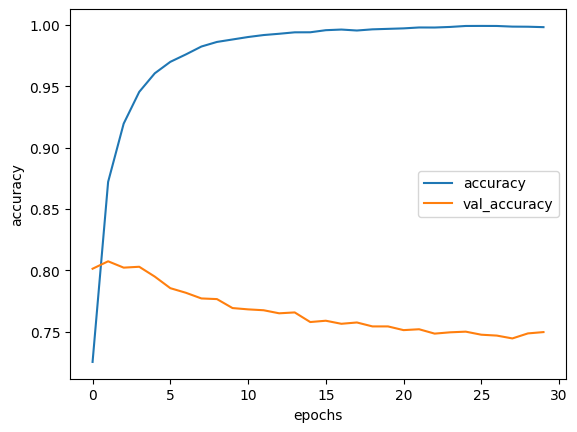

In [8]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['accuracy', 'val_accuracy'])
plt.show()

In [9]:
import csv

head = ['epochs', 'loss', 'accuracy', 'val_loss', 'val_accuracy']
with open("model1.csv", "w") as f:
  writer = csv.writer(f)
  writer.writerow(head)
  for i in range(len(history.history['loss'])):
    writer.writerow([i+1,
                     history.history[head[1]][i],
                     history.history[head[2]][i],
                     history.history[head[3]][i],
                     history.history[head[4]][i]])

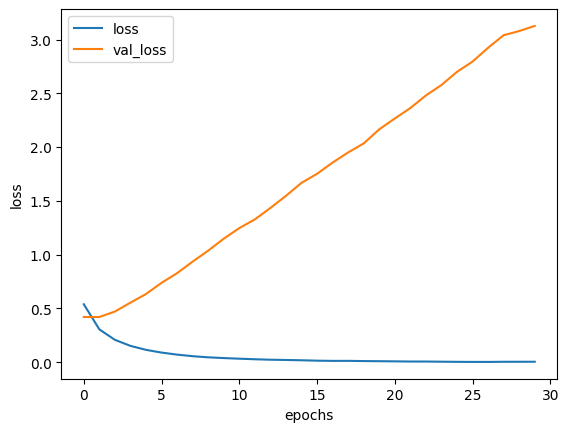

In [10]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['loss', 'val_loss'])
plt.show()

# 개선 후 모델

In [11]:
vocab_size = 2000 # 어휘 사전 크기 축소
embedding_dim = 7 # 임베딩 차원 바꾸기
max_length = 10
trunc_type = 'post'
padding_type = 'post'
oov_tok = "<OOV>"

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length,
                                padding=padding_type, truncating=trunc_type)
testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length,
                                padding=padding_type, truncating=trunc_type)

training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)

In [12]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(8, activation='relu',  # 데이터 수와 차원이 줄어들어 Dense 레이어 축소
                          kernel_regularizer = tf.keras.regularizers.l2(0.01)), # L1 규제
    # tf.keras.layers.Dropout(.25), # 드롭아웃, 이거하면 성능 안좋아짐
    tf.keras.layers.Dense(1, activation='sigmoid')
])

adam = tf.keras.optimizers.Adam(learning_rate=0.0001, # 학습률 바꾸기
                               beta_1=0.9, beta_2=0.999, amsgrad=False)

model.compile(loss='binary_crossentropy',
              optimizer=adam, metrics=['accuracy']) # 학습률 바꾸기

history = model.fit(training_padded, training_labels, epochs=100, # 차원축소로 학습속도 빨라졌으니 epoch 더 늘리기
                    validation_data=(testing_padded, testing_labels))

Epoch 1/100
719/719 [==============================] - 2s 2ms/step - loss: 0.7562 - accuracy: 0.5799 - val_loss: 0.7430 - val_accuracy: 0.6345
Epoch 2/100
719/719 [==============================] - 2s 2ms/step - loss: 0.7327 - accuracy: 0.6452 - val_loss: 0.7227 - val_accuracy: 0.6505
Epoch 3/100
719/719 [==============================] - 2s 2ms/step - loss: 0.7148 - accuracy: 0.6580 - val_loss: 0.7068 - val_accuracy: 0.6642
Epoch 4/100
719/719 [==============================] - 2s 2ms/step - loss: 0.7002 - accuracy: 0.6701 - val_loss: 0.6933 - val_accuracy: 0.6700
Epoch 5/100
719/719 [==============================] - 2s 2ms/step - loss: 0.6871 - accuracy: 0.6745 - val_loss: 0.6807 - val_accuracy: 0.6727
Epoch 6/100
719/719 [==============================] - 2s 3ms/step - loss: 0.6747 - accuracy: 0.6779 - val_loss: 0.6685 - val_accuracy: 0.6770
Epoch 7/100
719/719 [==============================] - 2s 3ms/step - loss: 0.6626 - accuracy: 0.6836 - val_loss: 0.6570 - val_accuracy: 0.6789

In [13]:
import csv

head = ['epochs', 'loss', 'accuracy', 'val_loss', 'val_accuracy']
with open("model2.csv", "w") as f:
  writer = csv.writer(f)
  writer.writerow(head)
  for i in range(len(history.history['loss'])):
    writer.writerow([i+1,
                     history.history[head[1]][i],
                     history.history[head[2]][i],
                     history.history[head[3]][i],
                     history.history[head[4]][i]])

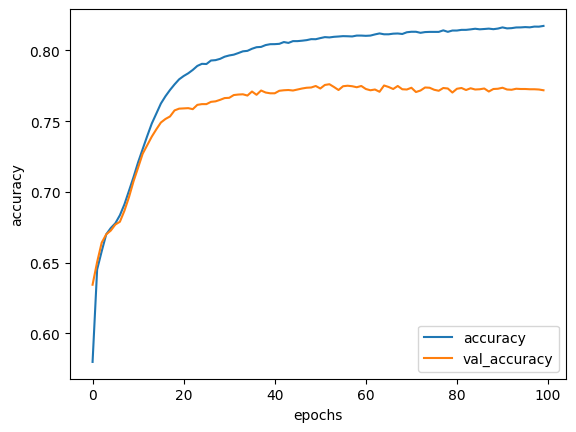

In [14]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['accuracy', 'val_accuracy'])
plt.show()

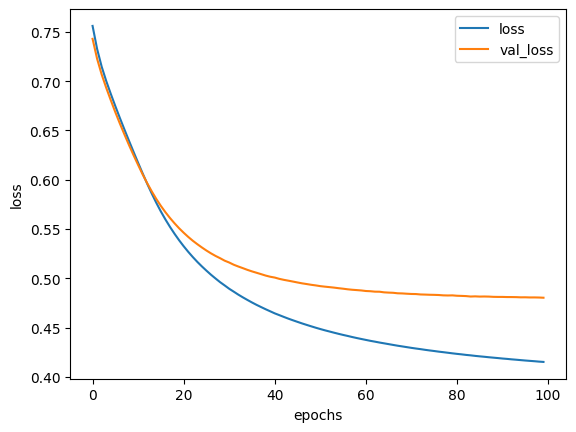

In [15]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['loss', 'val_loss'])
plt.show()

## LSTM 이용하기

In [16]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)), # 양방향 LSTM 이용
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

adam = tf.keras.optimizers.Adam(learning_rate=0.00001,
                                beta_1=0.9, beta_2=0.999, amsgrad=False)

model.compile(loss='binary_crossentropy',
              optimizer=adam, metrics=['accuracy'])

history = model.fit(training_padded, training_labels, epochs=100,
                    validation_data=(testing_padded, testing_labels))

Epoch 1/100
719/719 [==============================] - 11s 10ms/step - loss: 0.6928 - accuracy: 0.5505 - val_loss: 0.6924 - val_accuracy: 0.5561
Epoch 2/100
719/719 [==============================] - 5s 8ms/step - loss: 0.6921 - accuracy: 0.5408 - val_loss: 0.6917 - val_accuracy: 0.5405
Epoch 3/100
719/719 [==============================] - 6s 9ms/step - loss: 0.6914 - accuracy: 0.5300 - val_loss: 0.6909 - val_accuracy: 0.5368
Epoch 4/100
719/719 [==============================] - 5s 7ms/step - loss: 0.6907 - accuracy: 0.5342 - val_loss: 0.6900 - val_accuracy: 0.5394
Epoch 5/100
719/719 [==============================] - 7s 10ms/step - loss: 0.6898 - accuracy: 0.5391 - val_loss: 0.6890 - val_accuracy: 0.5481
Epoch 6/100
719/719 [==============================] - 5s 7ms/step - loss: 0.6887 - accuracy: 0.5511 - val_loss: 0.6878 - val_accuracy: 0.5597
Epoch 7/100
719/719 [==============================] - 7s 9ms/step - loss: 0.6874 - accuracy: 0.5609 - val_loss: 0.6864 - val_accuracy: 0.5

In [18]:
import csv

head = ['epochs', 'loss', 'accuracy', 'val_loss', 'val_accuracy']
with open("model3.csv", "w") as f:
  writer = csv.writer(f)
  writer.writerow(head)
  for i in range(len(history.history['loss'])):
    writer.writerow([i+1,
                     history.history[head[1]][i],
                     history.history[head[2]][i],
                     history.history[head[3]][i],
                     history.history[head[4]][i]])

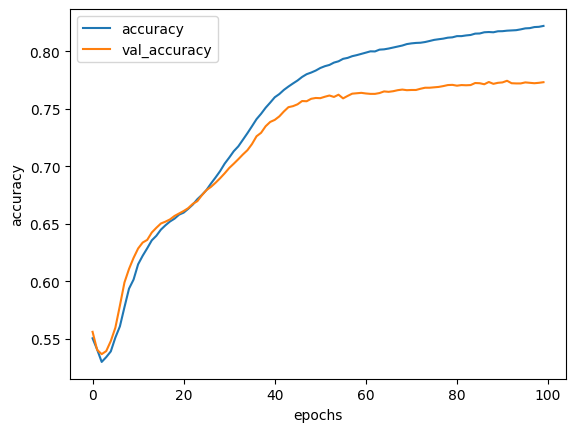

In [19]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['accuracy', 'val_accuracy'])
plt.show()

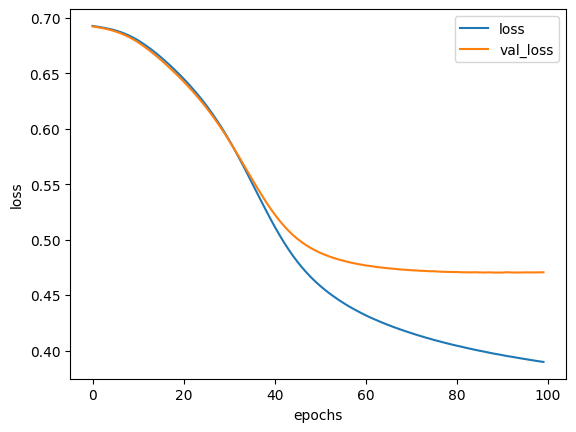

In [20]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['loss', 'val_loss'])
plt.show()

## Stacking LSTM 이용하기

In [21]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim,
                                                       return_sequences=True)), # LSTM끼리는 Sequence를 전달해야 함
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

adam = tf.keras.optimizers.Adam(learning_rate=0.00001,
                                beta_1=0.9, beta_2=0.999, amsgrad=False)

model.compile(loss='binary_crossentropy',
              optimizer=adam, metrics=['accuracy'])

history = model.fit(training_padded, training_labels, epochs=100,
                    validation_data=(testing_padded, testing_labels))

Epoch 1/100
719/719 [==============================] - 25s 22ms/step - loss: 0.6928 - accuracy: 0.5236 - val_loss: 0.6925 - val_accuracy: 0.5273
Epoch 2/100
719/719 [==============================] - 13s 18ms/step - loss: 0.6924 - accuracy: 0.5227 - val_loss: 0.6920 - val_accuracy: 0.5273
Epoch 3/100
719/719 [==============================] - 12s 16ms/step - loss: 0.6919 - accuracy: 0.5227 - val_loss: 0.6915 - val_accuracy: 0.5273
Epoch 4/100
719/719 [==============================] - 12s 16ms/step - loss: 0.6913 - accuracy: 0.5227 - val_loss: 0.6907 - val_accuracy: 0.5273
Epoch 5/100
719/719 [==============================] - 12s 17ms/step - loss: 0.6906 - accuracy: 0.5227 - val_loss: 0.6898 - val_accuracy: 0.5273
Epoch 6/100
719/719 [==============================] - 13s 18ms/step - loss: 0.6895 - accuracy: 0.5227 - val_loss: 0.6883 - val_accuracy: 0.5273
Epoch 7/100
719/719 [==============================] - 11s 15ms/step - loss: 0.6879 - accuracy: 0.5227 - val_loss: 0.6863 - val_ac

In [22]:
import csv

head = ['epochs', 'loss', 'accuracy', 'val_loss', 'val_accuracy']
with open("model4.csv", "w") as f:
  writer = csv.writer(f)
  writer.writerow(head)
  for i in range(len(history.history['loss'])):
    writer.writerow([i+1,
                     history.history[head[1]][i],
                     history.history[head[2]][i],
                     history.history[head[3]][i],
                     history.history[head[4]][i]])

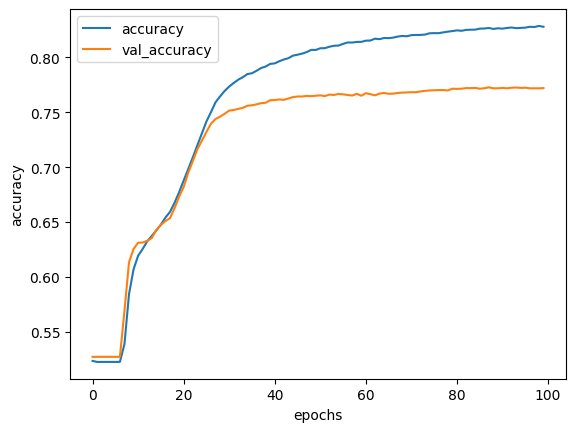

In [24]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['accuracy', 'val_accuracy'])
plt.show()

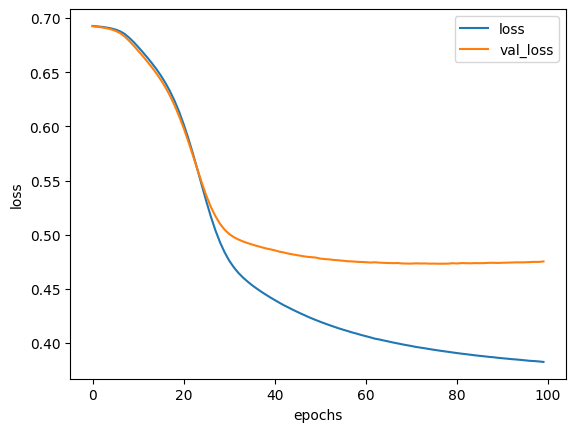

In [25]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['loss', 'val_loss'])
plt.show()

# 문장 분류해보기

In [ ]:
sentences = ["granny starting to fear spiders in the garden might be real",
             "game of thrones season finale showing this sunday night",
             "TensorFlow book will be a best seller",
             "AID is the best study club in the worlds"]

In [ ]:
sequences = tokenizer.texts_to_sequences(sentences)
print(sequences)

[[1, 803, 1, 753, 1, 1, 1, 1, 312, 1, 97], [123, 1, 1183, 160, 1, 1, 1, 1543, 152], [1, 235, 7, 1, 1, 47, 1], [1197, 1, 1, 47, 45, 1050, 1, 1, 277]]


In [ ]:
padded = pad_sequences(sequences, maxlen=max_length,
                       padding=padding_type, truncating=trunc_type)
print(padded)

[[   1  803    1  753    1    1    1    1  312    1]
 [ 123    1 1183  160    1    1    1 1543  152    0]
 [   1  235    7    1    1   47    1    0    0    0]
 [1197    1    1   47   45 1050    1    1  277    0]]


In [ ]:
print(model.predict(padded))

1/1 [==============================] - 0s 147ms/step
[[0.70872384]
 [0.13066499]
 [0.17384362]
 [0.7683838 ]]


> **AID is best study club in all of the worlds**

### 76.83%

위 문장은 빈정거리는 문장으로 판독되었습니다.